### Multiview SNE implementation

The algorithm is applied to the Caltech-101 dataset. But, unlike the case of standard t-SNE, here we use multiview data where each view corresponds to one RGB channel.

The code for the data preprocessing is stored in `preprocess_datasets.ipynb`.

The original paper on the algorithm: https://arxiv.org/pdf/2101.06763.pdf.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

### Datasets loading.

In [2]:
caltech_df0 = pd.read_csv('caltech_101_view0.csv')
caltech_df1 = pd.read_csv('caltech_101_view1.csv')
caltech_df2 = pd.read_csv('caltech_101_view2.csv')
caltech_features = [column for column in caltech_df0.columns if column.startswith('pixel')]
print(np.unique(caltech_df0.label.values))

['Faces' 'Faces_easy' 'Motorbikes' 'airplanes' 'watch']


In [3]:
multiview_X = [
    caltech_df0[caltech_features].values,
    caltech_df1[caltech_features].values,
    caltech_df2[caltech_features].values,
]

### Multi-view SNE.

In [10]:
import math
import numpy as np
import pylab
import sys

from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.neighbors import NearestNeighbors


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    if sumP == 0:
        sumP = 1
    if math.isinf(sumP):
        sumP = 1
    if math.isnan(sumP):
        sumP = 1
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def multiPCA(X=np.array([[]]), n_components=50):
    """
        runs PCA on M datasets, each being a NxD_i array in order to
        reduce their dimensionality to no_dims dimensions. PCA is applied
        on each dataset separately
    """
    
    dim = X.shape
    M = dim[0]
    Yout = X
    
    for view in range(M):
        XsetTemp = X[view]
        Xset = np.array(XsetTemp)
        (n,d) = Xset.shape
        Ytemp = Xset - np.tile(np.mean(Xset, 0), (n,1))
        (l,m) = np.linalg.eig(np.dot(Ytemp.T, Ytemp))
        Y = np.dot(Ytemp, m[:, 0:n_components])
        Yout[view] = Y

    return Yout

def multi_SNE(X=np.array([[]]), n_components=2, perplexity=30.0, n_iter=1000):
    initial_dims = X.shape[-1]

    # Initialize variables
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # Now, initialization for each data-set
    dim = X.shape
    M = dim[0]
    # Make sure each data-set has the same axis=0 dimension
    Xtemp = X[1]
    XsTemp = np.array(Xtemp)
    baselineDim = XsTemp.shape[0]

    Xpca = multiPCA(X, initial_dims).real
    a = [(0,0),(0,0), (0,0)]
    b = [(0,0),(0,0)]
    c = [(0,0),(0,0)]
    d = [(0,0),(0,0)]
    e = [(0,0),(0,0)]
    f = [(0,0),(0,0)]
    g = [(0,0),(0,0)]
   
    Y = np.random.randn(baselineDim, n_components)
    dY =  np.zeros((baselineDim, n_components))
    iY = np.zeros((baselineDim, n_components))
    gains = np.zeros((baselineDim, n_components))
    P = np.array([a, b, c, d, e, f][:M])
    
    # compute p-values
    for set in range(M):
        XsetTemp = Xpca[set]
        Xset = np.array(XsetTemp)
        (nI, dI) = Xset.shape
        
        # compute p-values for each data-set
        Ptemp = x2p(Xset, 1e-5, perplexity)
        (d1,d2) = Ptemp.shape
        k = np.argwhere(np.isnan(Ptemp))
        (kDim1, kDim2) = k.shape
        for i in range(kDim1):
            d1 = k[i][0]
            d2 = k[i][1]
            Ptemp[d1][d2] = 0
        Ptemp = Ptemp + np.transpose(Ptemp)
        Ptemp = Ptemp / np.sum(Ptemp)
        Ptemp = Ptemp * 4.      
        Ptemp = np.maximum(Ptemp, 1e-12)
        P[set] = Ptemp

    # algorithm iteration
    for iter in range(n_iter):
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(baselineDim), range(baselineDim)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        for set in range(M):
            Ptemp = P[set]
            Pset = np.array(Ptemp)
            PQ = Pset - Q
            
            if set == 0:
                for i in range(baselineDim):
                    dY[i, :] = np.sum(np.tile(PQ[:,i] * num[:,i], (n_components, 1)).T * (Y[i,:] - Y), 0)
            else:
                for i in range(baselineDim):
                    dY[i, :] = dY[i,:] + np.sum(np.tile(PQ[:,i] * num[:,i], (n_components, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
        (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y,0), (baselineDim,1))

        
        # update p-values
        for set in range(M):
            PsetTemp = P[set]
            Pset = np.array(PsetTemp)
            if (iter + 1) % 10 ==0:
                C = np.sum(Pset * np.log(Pset / Q))
                print("Iteration %d: error is %f" % (iter + 1, C))
            if iter == 100:
                Pset = Pset / 4.
                P[set] = Pset

    # Return solution
    return Y

In [11]:
tsne_results = multi_SNE(np.array(multiview_X), n_components=2, perplexity=30.0, n_iter=300)

Computing pairwise distances...
Computing P-values for point 0 of 2700...
Computing P-values for point 500 of 2700...
Computing P-values for point 1000 of 2700...
Computing P-values for point 1500 of 2700...
Computing P-values for point 2000 of 2700...
Computing P-values for point 2500 of 2700...
Mean value of sigma: 572.220069
Computing pairwise distances...
Computing P-values for point 0 of 2700...
Computing P-values for point 500 of 2700...
Computing P-values for point 1000 of 2700...
Computing P-values for point 1500 of 2700...
Computing P-values for point 2000 of 2700...
Computing P-values for point 2500 of 2700...
Mean value of sigma: 542.093469
Computing pairwise distances...
Computing P-values for point 0 of 2700...
Computing P-values for point 500 of 2700...
Computing P-values for point 1000 of 2700...
Computing P-values for point 1500 of 2700...
Computing P-values for point 2000 of 2700...
Computing P-values for point 2500 of 2700...
Mean value of sigma: 571.789909
Iteration 

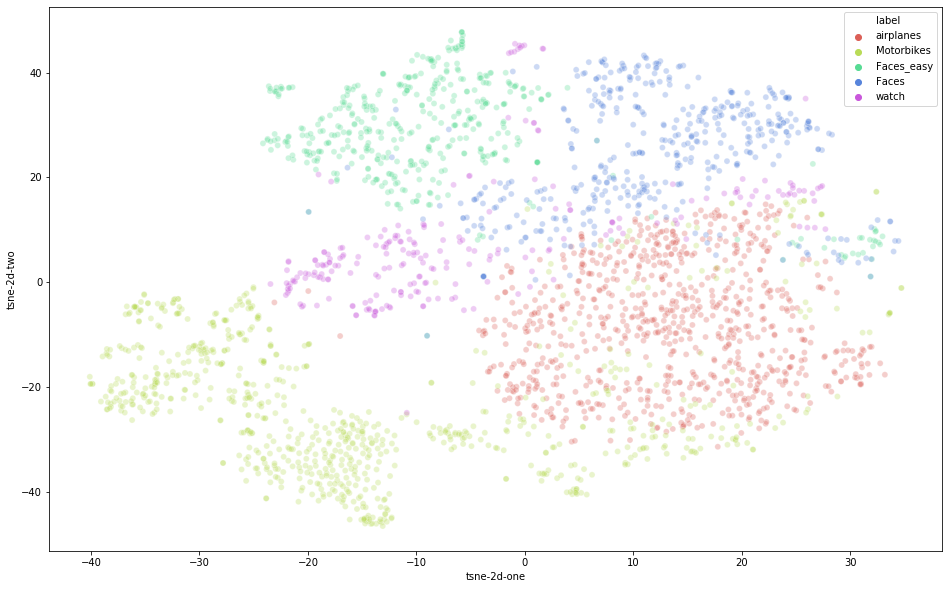

In [12]:
caltech_df0['tsne-2d-one'] = tsne_results[:,0]
caltech_df0['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=caltech_df0,
    legend="full",
    alpha=0.3
)